In [2]:
import os
import sys
import numpy as np 
import matplotlib.pyplot as plt


## **Ex 0. Getting Started: Cyclic Hopfield model**


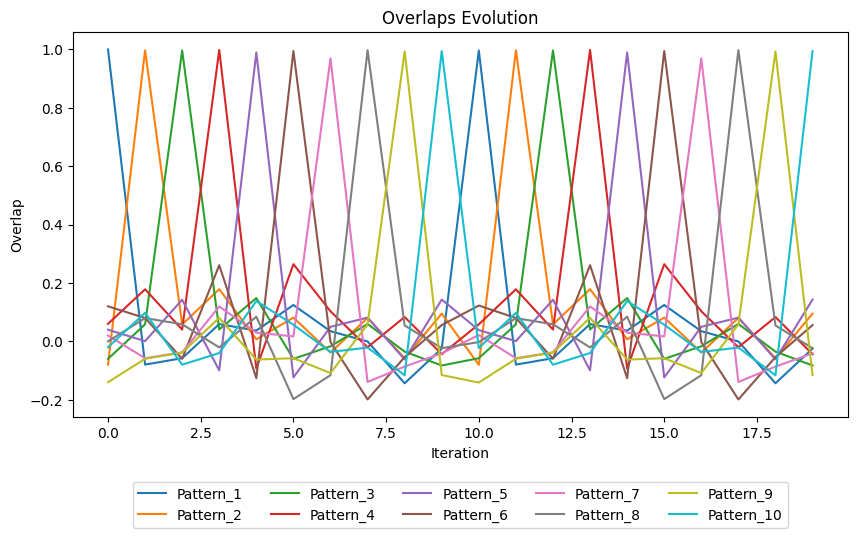

In [3]:
def generate_patterns(P,N): 
    """
    Generates P random flatt patterns of size N 
    Args:
        P (int): Number of patterns
        N (int): Size of each pattern
    """
    return np.random.choice([-1,1], size =(P, N))

def compute_overlaps(patterns, S): 
    """"
    Computes the overlaps between patterns P and state S
    Args:
        patterns (numpy.ndarray): Patterns of size (P, N)
        S (numpy.ndarray): State of size (N,)
    """
    N = patterns.shape[1]
    m = np.dot(patterns,S) / N
    return m #(P,)

def compute_state_S(m,patterns, S, beta): 
    """
    Computes the state S
    Args:
        patterns (numpy.ndarray): Patterns of size (P, N)
        S (numpy.ndarray): State of size (N,)
        beta (float): Scalar parameter
    """
    m_minus_1 = np.roll(m, 1)
    S_update = np.tanh(beta * np.dot(m_minus_1, patterns)) 
    return S_update #(N,)

def simulation(P = 10, N = 100, beta = 4, n_max = 20, plot= True):
    """
    Simulates the evolution of the state S and the overlaps m
    Args:
        P (int, optional): Number of patterns
        N (int, optional): Number of neurons
        beta (int, optional): Scalar parameter
        n_max (int, optional): Number of iterations
        plot (bool, optional): Whether to plot the overlaps evolution
    """
    m_track = []
    patterns = generate_patterns(P, N) 
    S= patterns[0,:].copy().astype(float) #initial state is the first pattern
    S_track = [S.copy()]
    for i in range(n_max): 
        m = compute_overlaps(patterns, S)
        S = compute_state_S(m, patterns, S, beta)
        S_track.append(S.copy())
        m_track.append(m)
    m_track = np.array(m_track)
    S_track = np.array(S_track)
    if plot : 
        plt.figure(figsize=(10, 5))
        for mu in range(P):
            plt.plot(m_track[:, mu], label=f'Pattern_{mu + 1}')
        plt.title('Overlaps Evolution')
        plt.xlabel('Iteration')
        plt.ylabel('Overlap')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=5, fancybox=True,)
        # plt.tight_layout()
        plt.show()
    
    return  patterns, S_track, m_track

sim = simulation()



    
    


    

## **Ex 1. Sequence storage and retrieval**


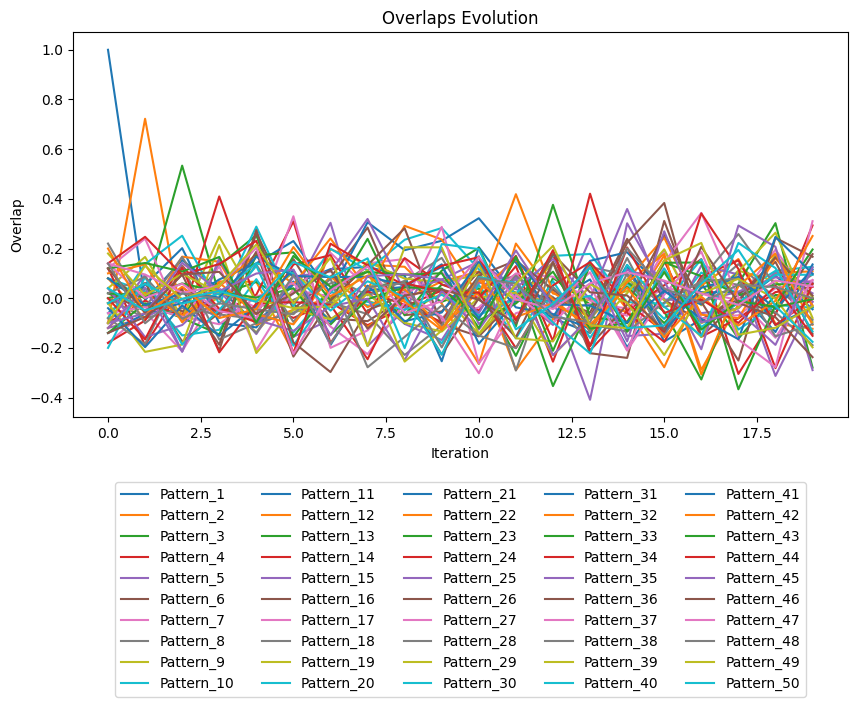

In [4]:
sim = simulation(P = 50)

In [23]:
def is_cycle_retreived( P = 10, N = 100, beta = 4, n_max = 20, plot= False):
    """
    Checks if the cycle is retrieved
    Args:
        m_stack (numpy.ndarray): Overlaps of size (n_max, P)
        P (int, optional): Number of patterns
        N (int, optional): Number of neurons
        beta (int, optional): Scalar parameter
        n_max (int, optional): Number of iterations
        plot (bool, optional): Whether to plot the overlaps evolution
    """
    _, _, m_stack = simulation(P, N, beta, n_max, plot)
    max_overlap = np.argmax(m_stack, axis=1)
    prev_index = max_overlap[0]
    for i in max_overlap[1:]:
        if prev_index == P-1:
            if i == prev_index or i == 0 :
                prev_index = i
                continue
            else:
                print("Cycle not retrieved")
                return False
        if i == prev_index or i == prev_index + 1:
            prev_index = i
            continue
        else:
            print("Cycle not retrieved")
            return False
          
    print("Cycle retrieved")
    return True
            
        
    
    
retreived = is_cycle_retreived()
  
     
    

Cycle retrieved


In [12]:
l = list(range(10))
l

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
for i in l[1:]:
    print(i)

1
2
3
4
5
6
7
8
9


In [6]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
a = np.array([10,4,0,1])
np.max(a)

10